<a href="https://colab.research.google.com/github/bbanzai88/Data-Science-Repository/blob/main/Autokeras_NAS__Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I am trying to predict the presence of tumors in images. I am using an evolutionary algorithm to find the optimal neural network (NN) architecture for the problem at hand. It’s especially valuable when:

*   You don’t know the ideal number of layers, neurons, or activation functions.
*   You want to discover non-obvious architectures that outperform standard choices.
*   You're dealing with small datasets (like medical imaging) where careful tuning matters.

The package we are using to identify the best neural network architecture is autokeras. AutoKeras is very easy to use, fully compatible with modern TensorFlow/Keras, and does a great job using evolutionary strategies to automate the neural network model architecture search.

In [1]:
!pip install -q autokeras
!pip install -q opencv-python



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.9 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()  # Upload brain_tumor_dataset.zip manually
#I got the training /testing  data from: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/code

import zipfile
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
     zip_ref.extractall("/content/")


Saving archive.zip to archive.zip


In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Custom mapping: consistent label encoding
CLASS_LABELS = ['glioma', 'meningioma', 'pituitary', 'notumor']

def load_brain_mri_multiclass(data_dir, img_size=64):
    X = []
    y = []

    for label_index, class_name in enumerate(CLASS_LABELS):
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (img_size, img_size))
                    X.append(img)
                    y.append(label_index)

    X = np.array(X).reshape(-1, img_size, img_size, 1).astype("float32") / 255.0
    y = to_categorical(np.array(y), num_classes=len(CLASS_LABELS))
    return X, y


In [4]:
train_dir = "/content/Training"
test_dir = "/content/Testing"

x_train, y_train = load_brain_mri_multiclass(train_dir)
x_test, y_test = load_brain_mri_multiclass(test_dir)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (5712, 64, 64, 1), y_train shape: (5712, 4)
x_test shape: (1311, 64, 64, 1), y_test shape: (1311, 4)


In [5]:
import autokeras as ak

# Initialize AutoKeras ImageClassifier
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,        # Number of model architecture trials
    seed=42
)

# Train the classifier
clf.fit(x_train, y_train, epochs=1) #epochs take forever so I reduced it from  10 and keeps  timing  out



Trial 1 Complete [00h 01m 27s]
val_loss: 1.470139980316162

Best val_loss So Far: 1.470139980316162
Total elapsed time: 00h 01m 27s
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 415ms/step - accuracy: 0.8023 - loss: 2.1036


In [6]:
# Evaluate performance
_, acc = clf.evaluate(x_test, y_test)
print(f"✅ Final Test Accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.1645 - loss: 1.4088
✅ Final Test Accuracy: 0.2571


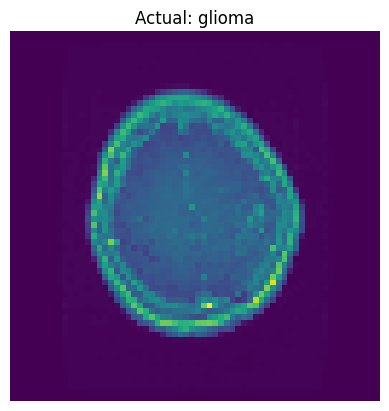

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
🤖 Predicted: pituitary


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


In [7]:
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

import matplotlib.pyplot as plt
import numpy as np

i = 0
plt.imshow(x_test[i])
plt.title("Actual: " + class_names[np.argmax(y_test[i])])
plt.axis('off')
plt.show()
predicted = clf.predict(np.expand_dims(x_test[i], axis=0))
predicted_label = class_names[int(np.argmax(predicted))]
print("🤖 Predicted:", predicted_label)